### Importing packages

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, chi2

### Downloading data from kaggle

In [5]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [32]:
! kaggle competitions download -c tabular-playground-series-aug-2022

  0% 0.00/2.27M [00:00<?, ?B/s]
100% 2.27M/2.27M [00:00<00:00, 134MB/s]


In [35]:
! ls 

kaggle.json  sample_submission.csv		     test.csv
sample_data  tabular-playground-series-aug-2022.zip  train.csv


In [34]:
! unzip tabular-playground-series-aug-2022.zip

Archive:  tabular-playground-series-aug-2022.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Datasets preparation

#### Load data 

Loading data from .csv files to pandas dataframes:

In [231]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Quick look on train and test datasets:

In [3]:
df_train

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,26565,E,158.95,material_7,material_6,6,9,6,16,4,...,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,26566,E,146.02,material_7,material_6,6,9,10,12,8,...,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,26567,E,115.62,material_7,material_6,6,9,1,10,1,...,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0
26568,26568,E,106.38,material_7,material_6,6,9,2,9,4,...,11.392,17.064,17.814,14.928,16.273,15.485,13.624,12.865,730.156,0


In [230]:
df_test

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,F,119.57,material_5,material_6,6,4,6,9,6,19.305,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,F,113.51,material_5,material_6,6,4,11,8,0,17.883,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,F,112.16,material_5,material_6,6,4,8,12,4,18.475,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,F,112.72,material_5,material_6,6,4,8,11,10,16.518,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,F,208.00,material_5,material_6,6,4,14,16,8,17.808,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,I,144.74,material_7,material_5,9,5,0,4,9,18.465,...,18.573,11.691,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466
20771,I,74.53,material_7,material_5,9,5,4,8,7,18.900,...,17.917,10.980,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249
20772,I,67.73,material_7,material_5,9,5,10,11,2,18.656,...,19.630,10.436,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349
20773,I,126.15,material_7,material_5,9,5,8,16,11,16.536,...,19.575,12.672,15.422,19.496,9.319,15.817,17.403,16.437,15.179,745.210


#### Class distribution

Class balance:

In [5]:
class_ratio = df_train['failure'].value_counts() / len(df_train)
print(class_ratio)

0    0.787392
1    0.212608
Name: failure, dtype: float64


Classes are unbalanced, there are more non-failure than failure products. Failure rate is 0.21. 

#### Data quality

Let's perform quick data quality test and see how many missing values there are in both datasets. 

In [22]:
train_miss_values = df_train.isna().sum()
test_miss_values = df_test.isna().sum()

train_miss_values_ratio = round(train_miss_values / len(df_train), 3)*100
test_miss_values_ratio = round(test_miss_values / len(df_test), 3)*100

pd.concat([train_miss_values.rename('train set missing values'), train_miss_values_ratio.rename('percent'),  test_miss_values.rename('test set missing values'), test_miss_values_ratio.rename('%_test')], axis=1)

,train set missing values,%,test set missing values,%
product_code,0,0.0,0.0,0.0
loading,250,0.9,223.0,1.1
attribute_0,0,0.0,0.0,0.0
attribute_1,0,0.0,0.0,0.0
attribute_2,0,0.0,0.0,0.0
attribute_3,0,0.0,0.0,0.0
measurement_0,0,0.0,0.0,0.0
measurement_1,0,0.0,0.0,0.0
measurement_2,0,0.0,0.0,0.0
measurement_3,381,1.4,329.0,1.6


Most features contain missing values, with percentages ranging from 0.9% to 8.6%. Therefore, some kind of imputation should be performed. 

First, lets create new datasets containing only numerical values. 

In [235]:
num_cols = [f for f in df_train.columns if (df_train[f].dtype == float or df_train[f].dtype == int)]

In [237]:
#remove labels ands ids colums to have only features columns names
num_cols.remove('failure')
num_cols.remove('id') 
num_cols

['loading',
 'attribute_2',
 'attribute_3',
 'measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [10]:
df_train_num = df_train[num_cols]
df_test_num = df_test[num_cols]
labels = df_train['failure']

#### Visualizing numerical data

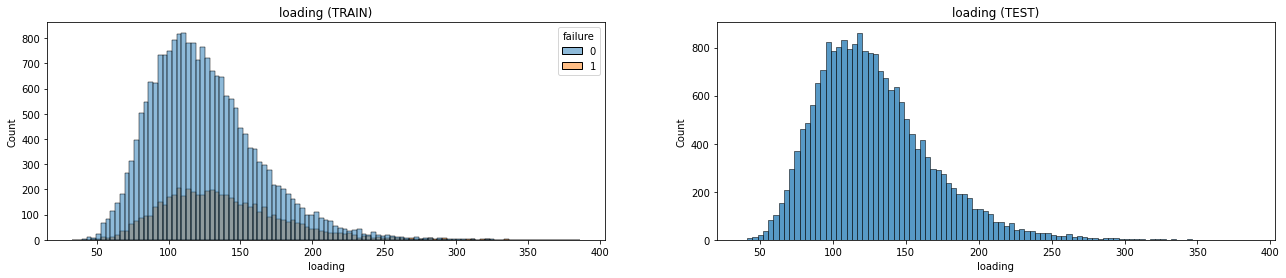

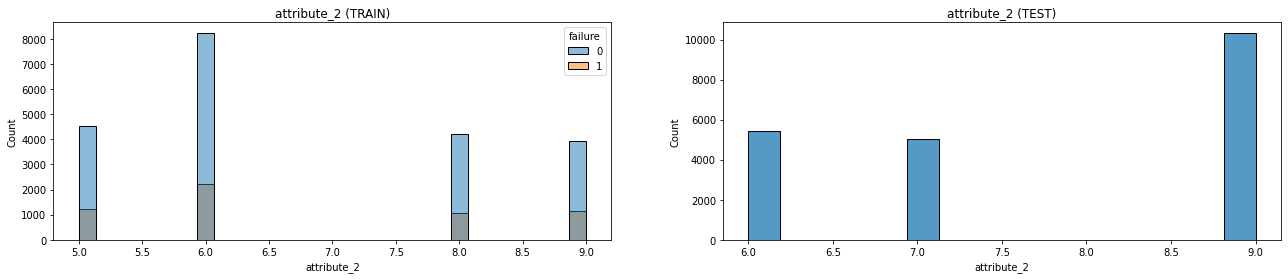

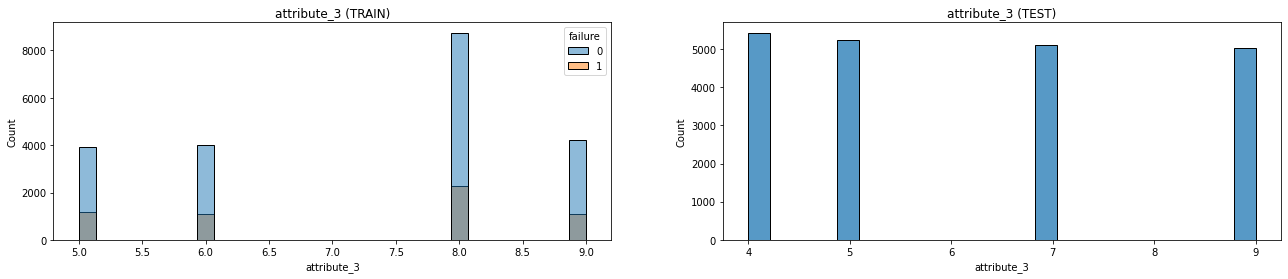

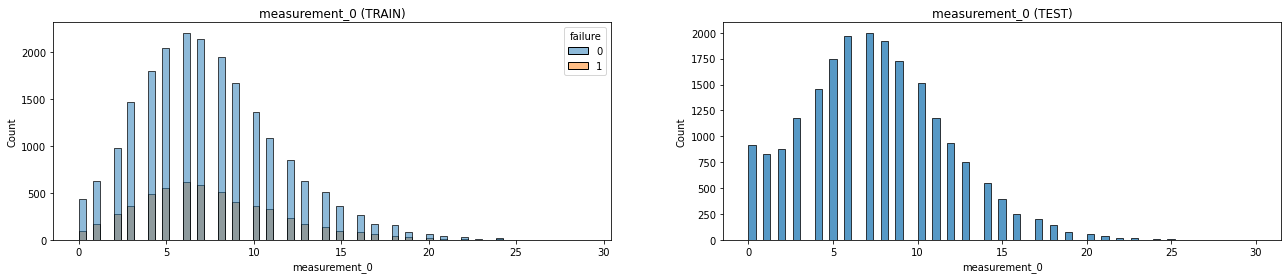

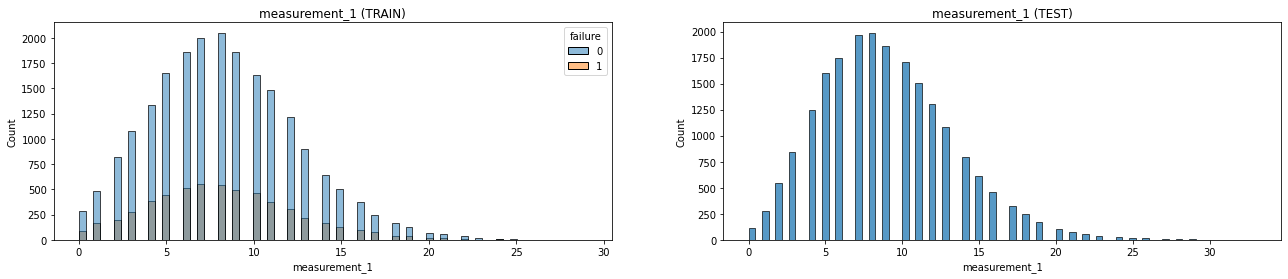

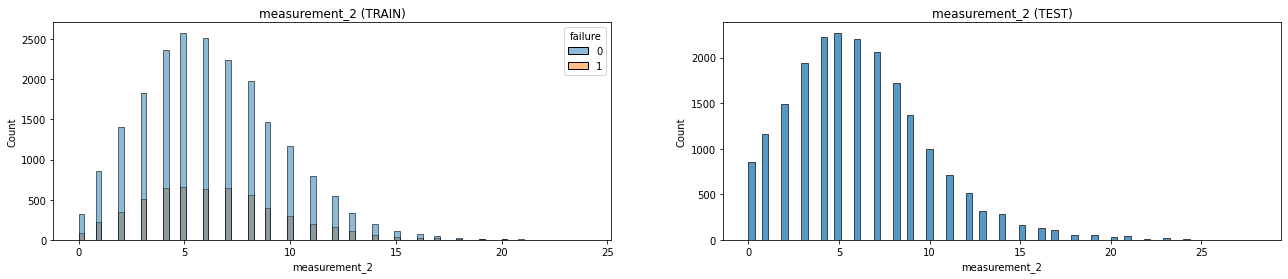

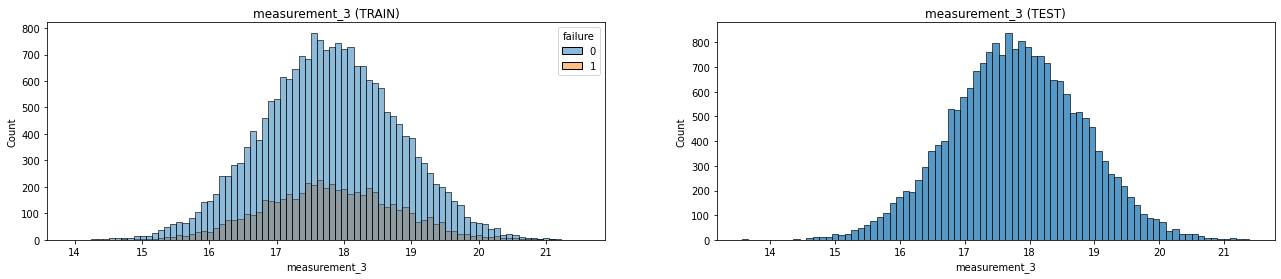

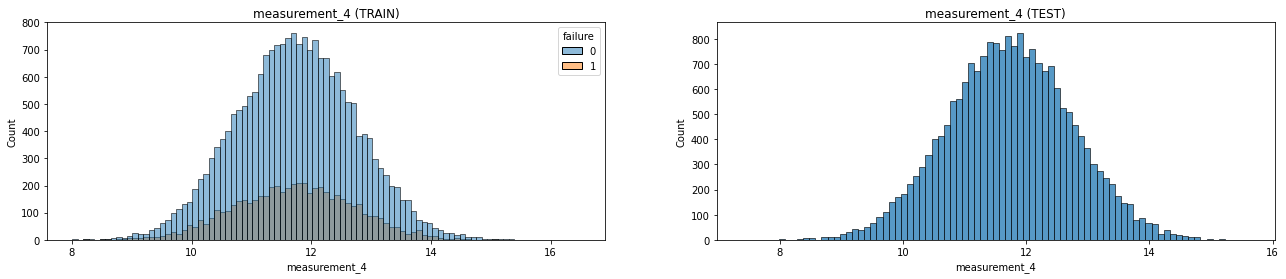

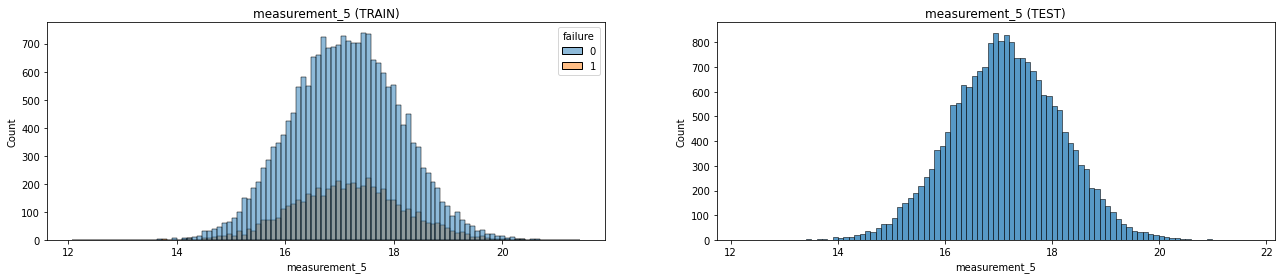

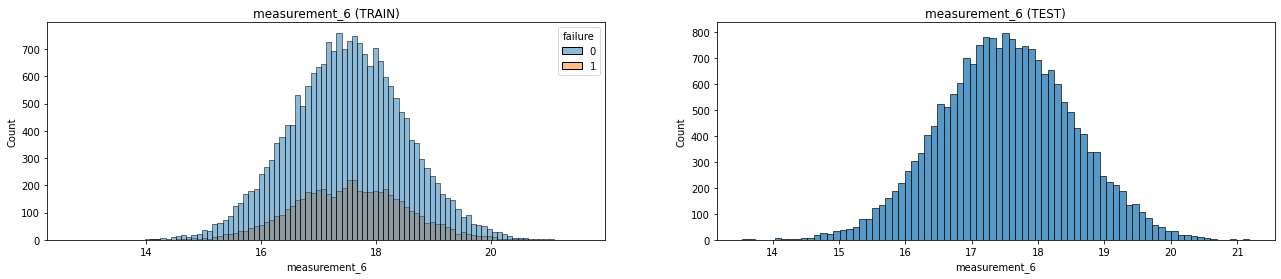

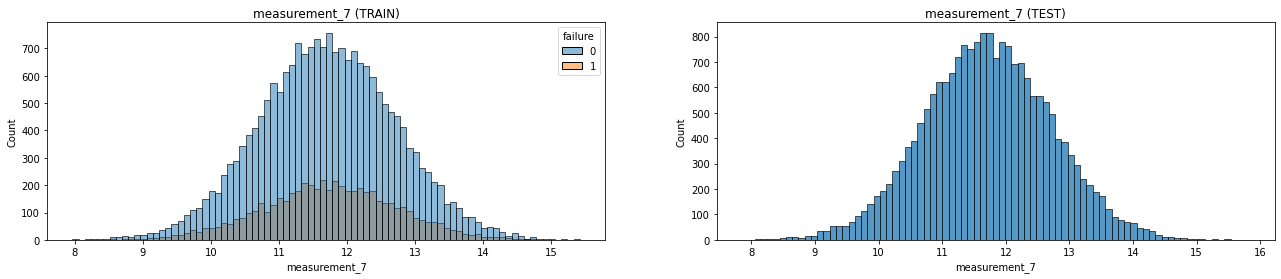

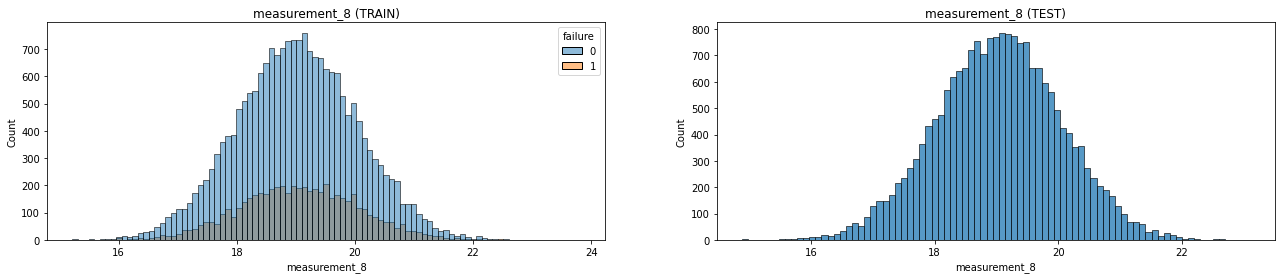

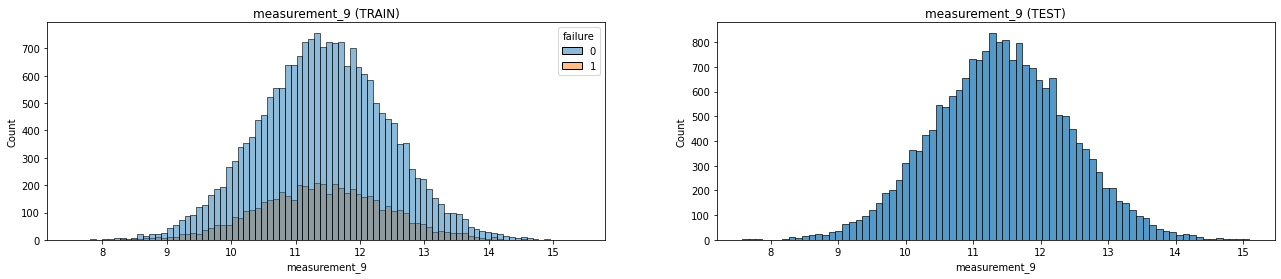

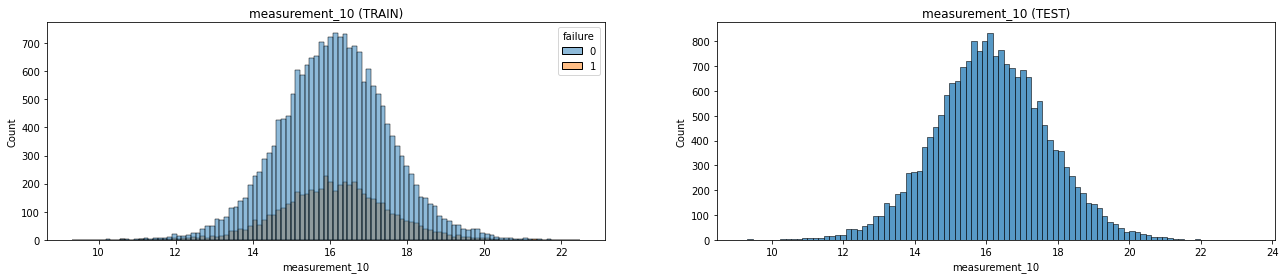

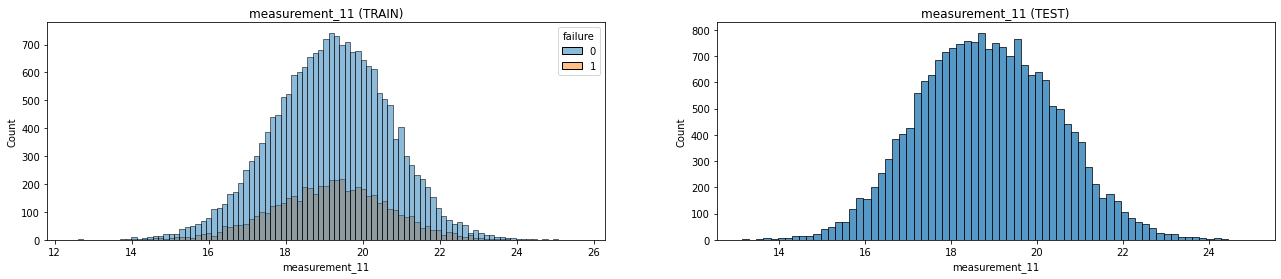

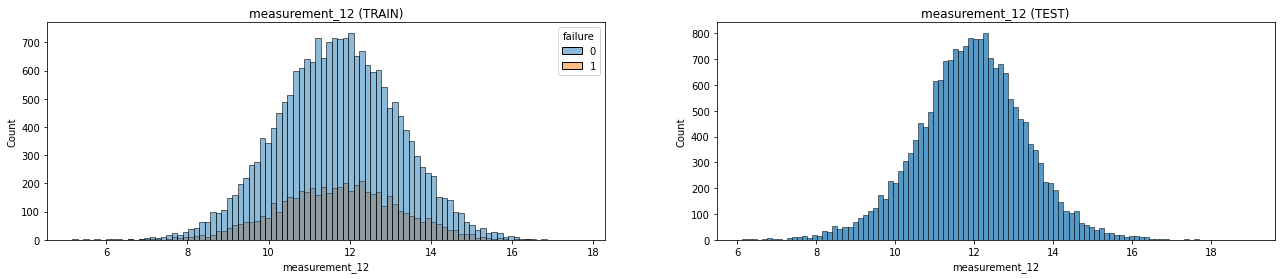

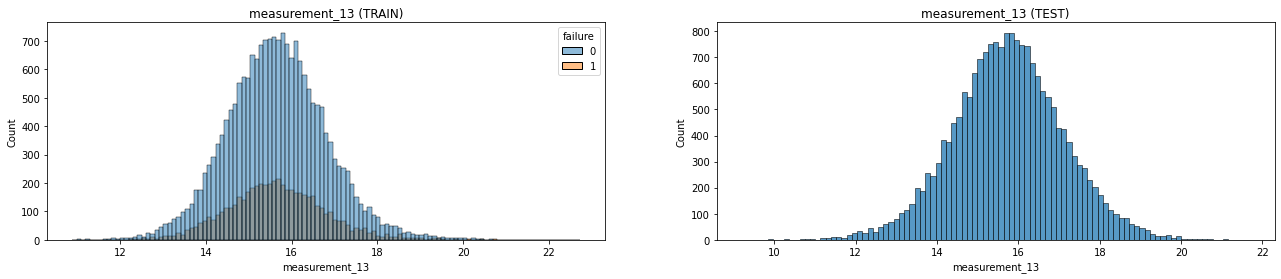

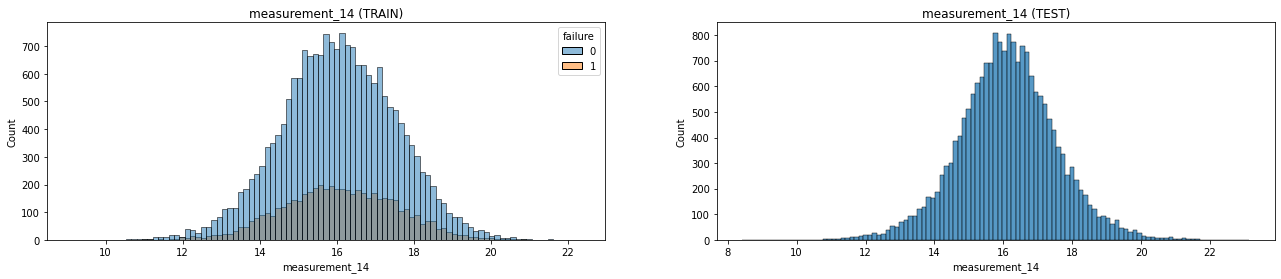

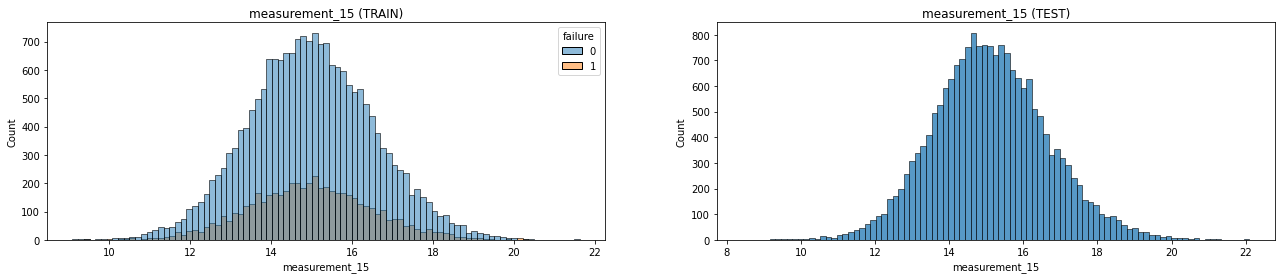

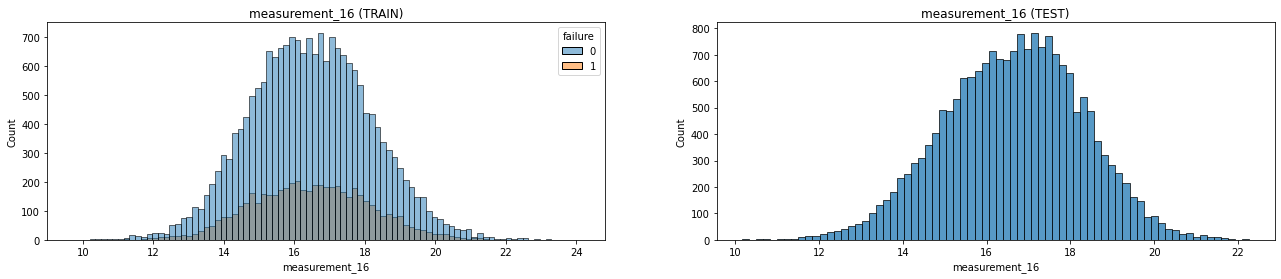

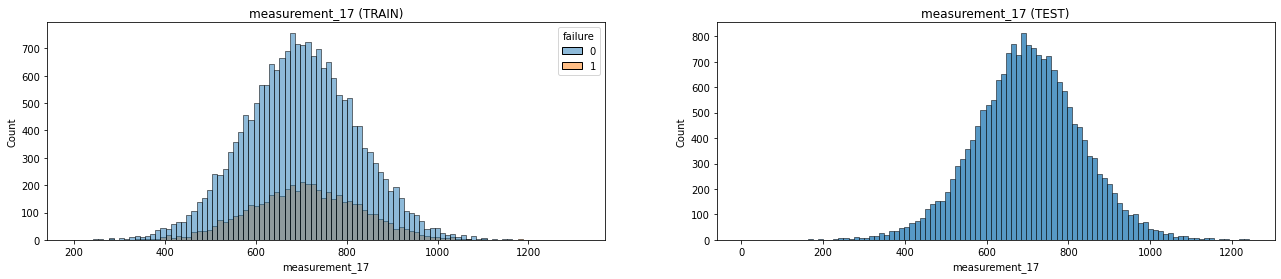

In [256]:
for feature in num_cols:
    plt.figure(figsize=(22,4))
    plt.subplot(1,2,1)
    sns.histplot(data=df_train, x=feature, hue='failure')
    plt.title(feature+' (TRAIN)')

    plt.subplot(1,2,2)
    sns.histplot(data=df_test, x=feature)
    plt.title(feature+' (TEST)')

    plt.show()

Variables *loading* and *measurements_{3, ..., 17}* are continous variables and their distribution apear to follow Gaussian distribution. Variables  *measurements_{0, ..., 2}* are discrete variable and apear to follow Poisson distribution. Variables from *attribute* group contain only several unevenly spaced values. All the shown class distributions in each feature overlap, so the features do not separate well. 

#### Imputing missing values

Time for data imputation. Data imputation is performed using *KNNImputer* from *sklearn.impute* package. KNNImputer is imputation for completing missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close. [[KNNImputer]](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

In [149]:
imputer = KNNImputer(n_neighbors=3)
train_num_filled = imputer.fit_transform(df_train_num)
test_num_filled = imputer.fit_transform(df_test_num)

In [257]:
df_train_num_filled = pd.DataFrame(train_num_filled)
df_train_num_filled.columns = num_cols
df_test_num_filled = pd.DataFrame(test_num_filled)
df_test_num_filled.columns = num_cols

#### Correlations and feature selection

Text(0.5, 1.0, 'Correlations')

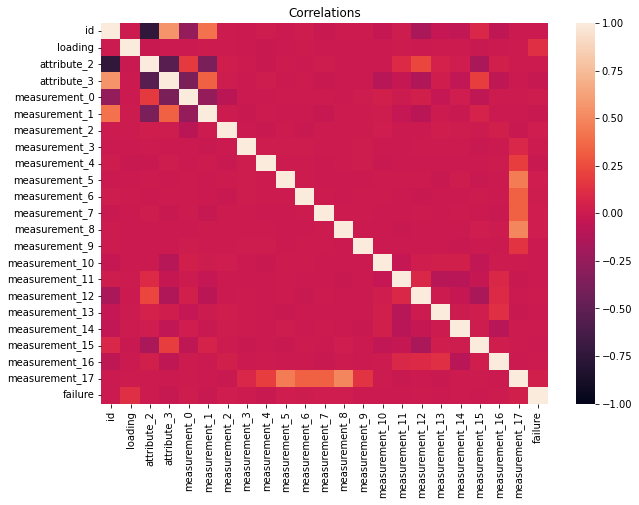

In [317]:
plt.figure(figsize=(10,7))
sns.heatmap(df_train.corr(), vmin=-1, vmax=1)
plt.title('Correlations')

In [54]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_train_num_filled,labels)

In [283]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_train_num.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
featureScores = featureScores.sort_values(by=['Score'], ascending = False)
featureScores

,Feature,Score
0,loading,5199.349577
20,measurement_17,561.549886
5,measurement_2,11.619603
4,measurement_1,6.650705
3,measurement_0,5.649334
2,attribute_3,2.876265
8,measurement_5,0.514242
10,measurement_7,0.489800
11,measurement_8,0.375974
1,attribute_2,0.342218


Text(0.5, 1.0, 'feature importance')

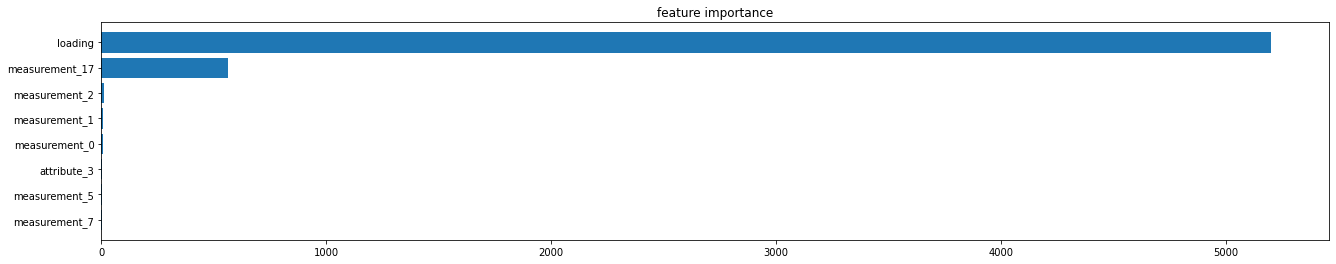

In [284]:
plt.figure(figsize=(22,4))
plt.barh(featureScores.Feature[0:8], featureScores.Score[0:8])
plt.gca().invert_yaxis()
plt.title('feature importance')

### Linear model

Let's train simple linear regression model on all the given features(tests have shown this way gives the best results). 

In [219]:
x_train, x_dev, y_train, y_dev = train_test_split(df_train_num_filled, labels, test_size=0.3, shuffle=True)

In [220]:
lin_reg_model = LogisticRegression(penalty = 'l1', C=0.05, solver='liblinear').fit(x_train, y_train)

In [285]:
print("Roc auc score: ")
print(round(roc_auc_score(y_dev, lin_reg_model.predict_proba(x_dev)[:,1]), 3))

Roc auc score: 
0.593


AUC ROC score was calculated as it is metric for this kaggle competition.

### Submission

The last step is to prepare a submission file in kaggle competition format, which has to be a .csv file with two columns - product id and probability of failure). 

In [223]:
test_pred = lin_reg_model.predict_proba(df_test_num_filled)[:,1]

In [224]:
test_pred

array([0.22251864, 0.17401018, 0.20410275, ..., 0.13736261, 0.21732044,
       0.17668092])

In [234]:
submission = pd.DataFrame({'id': df_test['id'],
                           'failure': test_pred})
submission.to_csv('submission.csv', index=False)
submission

,id,failure
0,26570,0.222519
1,26571,0.174010
2,26572,0.204103
3,26573,0.201019
4,26574,0.354311
...,...,...
20770,47340,0.233234
20771,47341,0.166884
20772,47342,0.137363
20773,47343,0.217320
